In [423]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier

In [424]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.width", 500)

# Datasets

In [425]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
sample = pd.read_csv("Data/sample_submission.csv")

In [426]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,1.00,0.00,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,1.00,1.00,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,1.00,0.00,184866.69,0
3,3,15741417,Kao,581,France,Male,34.00,2,148882.54,1,1.00,1.00,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,1.00,1.00,15068.83,0


In [427]:
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

In [428]:
def data_summary(dataframe):
    print("############## SHAPE ##############")
    print(dataframe.shape[0])
    print("############## TYPES ##############")
    print(dataframe.dtypes)
    print("############## NULL ##############")
    print(dataframe.isnull().sum())
    print("############ DESCRIBE ############")
    print(dataframe.describe([0.0, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T)

In [429]:
data_summary(train)

############## SHAPE ##############
165034
############## TYPES ##############
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object
############## NULL ##############
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
############ DESCRIBE ############
                    count        mean      std         min          0%         25%         50%         75%         90%         95%         99%         max
CustomerId      165034.00 15692005.02 71397.8

In [430]:
data_summary(test)

############## SHAPE ##############
110023
############## TYPES ##############
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object
############## NULL ##############
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64
############ DESCRIBE ############
                    count        mean      std         min          0%         25%         50%         75%         90%         95%         99%         max
CustomerId      110023.00 15692096.61 71684.99 15565701.00 15565701.00 15632859.00 15690175.0

In [431]:
train["Geography"].value_counts()

France     94215
Spain      36213
Germany    34606
Name: Geography, dtype: int64

In [432]:
pd.DataFrame({
    "Customer_count" : train.groupby(["Geography", "Gender"])["CustomerId"].count(),
    "Exited_count": train.groupby(["Geography", "Gender"])["Exited"].sum(),
    "Target_ratio": (train.groupby(["Geography", "Gender"])["Exited"].sum() / train.groupby("Geography")["CustomerId"].count()) *100,
    "Total_ratio": (train.groupby(["Geography", "Gender"])["Exited"].sum() / train["Exited"].shape[0]) *100,
    "Salary_mean": train.groupby(["Geography", "Gender"])["EstimatedSalary"].mean()
})

Customer_count  Exited_count  Target_ratio  Total_ratio  Salary_mean
Geography Gender                                                                      
France    Female           39976          9002          9.55         5.45    112752.81
          Male             54239          6570          6.97         3.98    112285.74
Germany   Female           16388          7596         21.95         4.60    114748.88
          Male             18218          5518         15.95         3.34    113085.45
Spain     Female           15520          3507          9.68         2.13    111883.21
          Male             20693          2728          7.53         1.65    111336.08

In [433]:
train["Surname"].nunique()

2797

In [434]:
train["Surname"].value_counts()[0:10]

Hsia       2456
T'ien      2282
Hs?        1611
Kao        1577
Maclean    1577
Ts'ui      1567
P'eng      1503
H?         1420
Hsueh      1306
Shih       1251
Name: Surname, dtype: int64

In [435]:
train["CustomerId"].nunique()

23221

In [436]:
customer_list = train["CustomerId"].unique()
len(customer_list)

23221

In [437]:
train.loc[train["Age"] == 92]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
17173,15723373,Hsia,543,France,Male,92.00,6,0.00,2,1.00,1.00,61290.99,0
43508,15660878,T'ien,752,France,Male,92.00,1,126076.24,2,1.00,1.00,34436.83,0
59479,15691624,Chidiebere,820,France,Male,92.00,0,0.00,2,1.00,1.00,23067.97,0
62569,15660871,Ch'iu,774,Spain,Male,92.00,9,126076.24,2,1.00,1.00,34436.83,0
74699,15660878,T'ien,696,France,Male,92.00,9,0.00,1,0.00,1.00,163563.07,1
116359,15655961,Palermo,790,France,Male,92.00,1,0.00,2,0.00,1.00,93302.29,0
121560,15660878,T'ien,775,Spain,Male,92.00,1,126076.24,2,1.00,1.00,34436.83,0
136841,15764927,Rogova,753,France,Male,92.00,3,121513.31,1,1.00,0.00,195563.99,0
162163,15589975,Maclean,721,France,Female,92.00,3,97259.25,2,0.00,1.00,104719.66,0
163138,15721917,Lung,684,France,Female,92.00,3,95139.41,1,1.00,1.00,86575.46,0


In [438]:
train.loc[train["CustomerId"] == 15660878]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1329,15660878,T'ien,743,France,Male,76.00,9,126076.24,1,1.00,1.00,34436.83,0
11256,15660878,Ndubueze,714,Spain,Male,25.00,1,0.00,2,1.00,1.00,103381.77,0
43508,15660878,T'ien,752,France,Male,92.00,1,126076.24,2,1.00,1.00,34436.83,0
49584,15660878,Flannery,638,France,Male,39.00,3,0.00,2,0.00,1.00,105080.53,0
74699,15660878,T'ien,696,France,Male,92.00,9,0.00,1,0.00,1.00,163563.07,1
86176,15660878,T'ien,545,Germany,Female,38.00,3,114754.08,1,1.00,0.00,136050.44,0
94261,15660878,T'ien,705,France,Male,42.00,1,126076.24,2,1.00,1.00,34436.83,0
121560,15660878,T'ien,775,Spain,Male,92.00,1,126076.24,2,1.00,1.00,34436.83,0
139905,15660878,Brown,610,France,Female,47.00,1,0.00,2,0.00,1.00,80178.54,0


In [439]:
pd.pivot_table(data=train, index=["CustomerId", "Surname", "Geography", "Gender"], values=["Age", "NumOfProducts"] ).head(30)

Age  NumOfProducts
CustomerId Surname    Geography Gender                     
15565701   Bruno      Spain     Male   49.00           2.00
           Chineze    France    Male   32.00           1.00
           Ferri      France    Female 39.00           1.00
15565706   Akobundu   France    Male   37.00           1.00
                      Spain     Male   35.00           1.00
           Chung      Germany   Male   39.00           2.00
           McGregor   France    Male   34.00           2.00
15565714   Cattaneo   Spain     Male   47.00           2.00
           Davis      France    Female 34.00           2.00
           Yermakov   France    Male   38.00           1.00
15565759   Uwakwe     France    Female 59.00           1.00
15565779   Ch'in      Germany   Female 43.00           1.00
           De Luca    France    Male   38.00           2.00
           Kao        France    Female 36.00           1.00
           Lai        France    Female 40.00           2.00
           Trevisani  France    Male   31.00           2.00
15565796   Docherty   France    Male   39.00           1.00
                      Germany   Female 32.00           1.00
                                Male   48.00           1.00
           P'eng      Germany   Male   52.00           1.00
           Palerma    France    Male   36.00           2.00
           Toscani    France    Male   20.00           1.00
           Y?an       France    Female 34.00           2.00
           Yermakov   France    Female 35.00           2.00
15565806   Chidubem   France    Male   38.00           1.00
           Lockington France    Male   54.00           2.00
           Nucci      Spain     Female 33.00           1.00
           Obialo     France    Male   44.00           2.00
           Toosey     France    Male   34.00           1.00
           Zetticci   Spain     Male   40.00           2.00

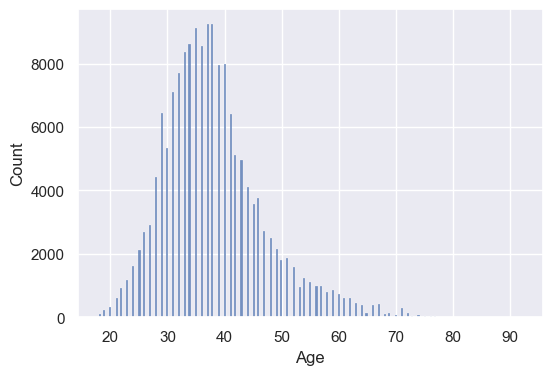

In [440]:
sns.histplot(data=train, x = "Age")
plt.show()

In [441]:

train["Status"] = pd.cut(train["Age"],
                          bins = [train["Age"].min(), 22, 55, train["Age"].max()],
                          labels= ["Student","Employee","Retired"])

In [442]:
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Status
0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,1.00,0.00,181449.97,0,Employee
1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,1.00,1.00,49503.50,0,Employee
2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,1.00,0.00,184866.69,0,Employee
3,15741417,Kao,581,France,Male,34.00,2,148882.54,1,1.00,1.00,84560.88,0,Employee
4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,1.00,1.00,15068.83,0,Employee


In [443]:
test["Status"] = pd.cut(test["Age"],
                          bins = [test["Age"].min(), 22, 55, test["Age"].max()],
                          labels= ["Student","Employee","Retired"])

<Axes: xlabel='Status', ylabel='EstimatedSalary'>

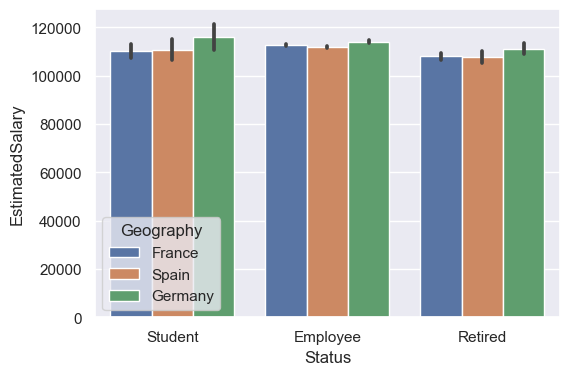

In [444]:
sns.barplot(x = "Status", 
            y = "EstimatedSalary", 
            hue = "Geography" ,
            data = train)

<Axes: xlabel='Status', ylabel='Balance'>

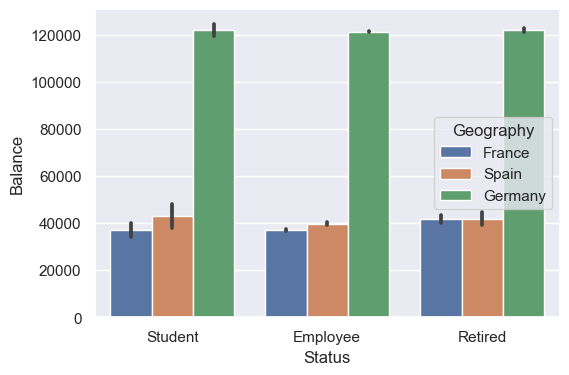

In [445]:
sns.barplot(x = "Status", 
            y = "Balance", 
            hue = "Geography" ,
            data = train)

In [446]:
train.groupby("Status")["EstimatedSalary"].mean()

Status
Student    111169.84
Employee   112809.91
Retired    108827.28
Name: EstimatedSalary, dtype: float64

In [447]:
train.groupby("Status")["Balance"].mean()

Status
Student    51610.92
Employee   55154.18
Retired    62303.80
Name: Balance, dtype: float64

In [448]:
train["Empty_Balance"] = np.where(train["Balance"] == 0.00, 0, 1)   
test["Empty_Balance"] = np.where(test["Balance"] == 0.00, 0, 1)   

<Axes: xlabel='Exited', ylabel='Empty_Balance'>

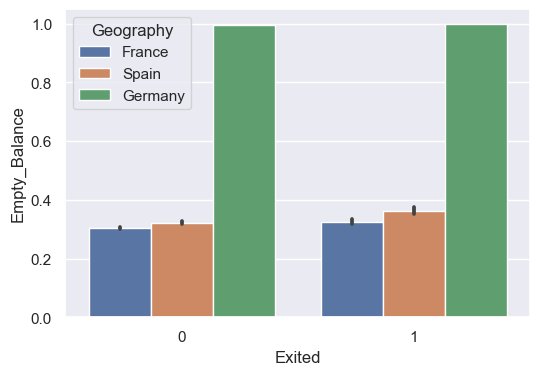

In [449]:
sns.barplot(x = "Exited", 
            y = "Empty_Balance", 
            hue = "Geography" ,
            data = train)

In [450]:
# Label Encoder

lab = LabelEncoder()
train["Gender"] = lab.fit_transform(train["Gender"])
print(lab.inverse_transform([0,1]))

test["Gender"] = lab.fit_transform(test["Gender"])
print(lab.inverse_transform([0,1]))

train["Geography"] = lab.fit_transform(train["Geography"])
print(lab.inverse_transform([0,1,2]))

test["Geography"] = lab.fit_transform(test["Geography"])
print(lab.inverse_transform([0,1,2]))

train["Status"] = lab.fit_transform(train["Status"])
print(lab.inverse_transform([0,1,2]))

test["Status"] = lab.fit_transform(test["Status"])
print(lab.inverse_transform([0,1,2]))

['Female' 'Male']
['Female' 'Male']
['France' 'Germany' 'Spain']
['France' 'Germany' 'Spain']
['Employee' 'Retired' 'Student']
['Employee' 'Retired' 'Student']


C:\Users\BETÜL DEMİRDAĞ\AppData\Local\Temp\ipykernel_16104\822323674.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()[['Exited']]


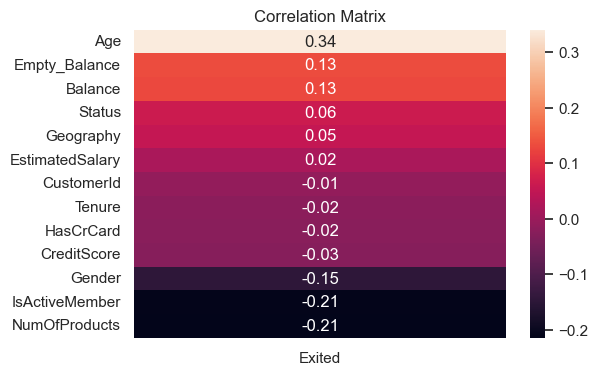

In [451]:
corr_matrix = train.corr()[['Exited']]
sns.set(rc={'figure.figsize': (6, 4)})
corr_matrix.drop(['Exited'], axis=0, inplace=True)
sns.heatmap(corr_matrix.sort_values(by='Exited', ascending=False), annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [452]:
train.drop(["CustomerId", "Surname"], axis = 1, inplace=True)
test.drop(["CustomerId", "Surname"], axis = 1, inplace=True)

In [453]:
# One Hot Encoder
one_hot_columns = ["Empty_Balance", "Status", "Geography", "Gender", "HasCrCard", "IsActiveMember"]
train = pd.get_dummies(train, columns=one_hot_columns, drop_first=True)
test = pd.get_dummies(test, columns=one_hot_columns, drop_first=True)
train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Empty_Balance_1,Status_1,Status_2,Status_3,Geography_1,Geography_2,Gender_1,HasCrCard_1.0,IsActiveMember_1.0
0,668,33.00,3,0.00,2,181449.97,0,0,0,0,0,0,0,1,1,0
1,627,33.00,1,0.00,2,49503.50,0,0,0,0,0,0,0,1,1,1
2,678,40.00,10,0.00,2,184866.69,0,0,0,0,0,0,0,1,1,0
3,581,34.00,2,148882.54,1,84560.88,0,1,0,0,0,0,0,1,1,1
4,716,33.00,5,0.00,2,15068.83,0,0,0,0,0,0,1,1,1,1


In [454]:
y_train = train["Exited"]
x_train = train.drop(["Exited"], axis = 1)
x_test = test

In [455]:
model = RandomForestClassifier(random_state = 46).fit(x_train, y_train)
pred = model.predict(x_test)